## Задание 4. Найти выбросы

#### Описание задачи:

В этом датасете – выборка из значений величины трафика на одной из российских дорог. В переменной **volume** находится истинное количество транспортных средств, зарегистрированное на определенном километре в определенное время, а в **volume_calc** – это же количество минус количество транспортных средств, чье местоположение по тем или иным причинам разглашать нельзя.

Для соревнования по прогнозированию ДТП в датасете необходимо было оставить только “публичную” переменную **volume_calc**, однако в тех случаях, когда разрыв между **volume** и **volume_calc** аномально велик, эта переменная не информативна для ML-модели. Поэтому было решено оставить лишь информативные значения **volume_calc**, а прочие заменить на пропуски.

Предложите стратегию, какие значения **volume_calc** стоит заменить на пропуски. *Подсказка: при построении моделей машинного обучения количественные переменные обычно нормализуются, поэтому любая переменная там может быть представлена с точностью до линейного преобразования.*

In [1]:
# Импорт библиотек
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

matplotlib.style.use('seaborn')
%matplotlib inline

In [2]:
# Чтение данных
df = pd.read_csv('traffic_sample.csv')
df.head()

,volume,volume_calc
0,12.0,10.0
1,234.0,230.0
2,26.0,26.0
3,20.0,16.0
4,42.0,42.0


### Шаг 1

Изучим разницу между переменными volume и volume_calc: посмотрим описательные статистики, определим характер распределения переменных

In [3]:
# Общая информация по датасету, проверка пропущенных значений
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   volume       100000 non-null  float64
 1   volume_calc  100000 non-null  float64
dtypes: float64(2)
memory usage: 1.5 MB


In [4]:
# Считаем разницу (дельту) между volume и volume_calc, выводим описательные статистики этой разницы
df['delta'] = df['volume'] - df['volume_calc']
df.delta.describe()

count    100000.000000
mean          6.558090
std         165.283642
min        -235.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       21374.000000
Name: delta, dtype: float64

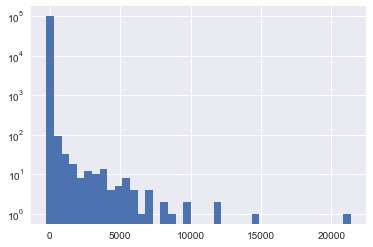

In [5]:
# Распределение переменной дельта на гистограмме, (прологарифмирована по шкале y для наглядности)
plt.hist(df.delta, log=True, bins=40);

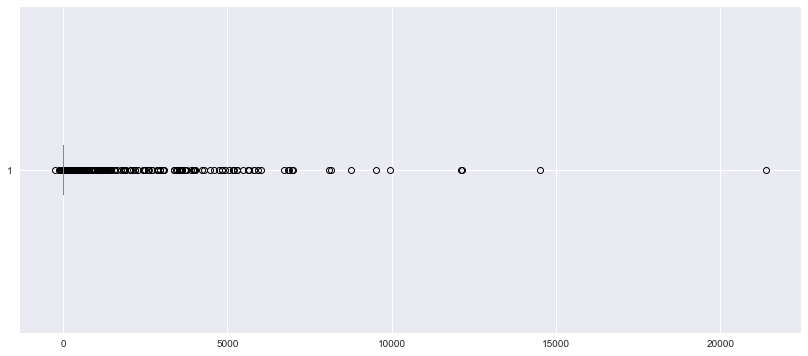

In [6]:
# также распределение по ящику с усами
fig, ax = plt.subplots(figsize=(14,6))
ax.boxplot(df.delta, vert=False);

### Первые выводы: 

* Большинство значений дельта сосредоточено на 0: первый и третий квартили равны нулю
* Имеются сильные выбросы вправо (max = 21 374), которые, однако, не сильно искажают среднее значение
* В дельте оказались минусовые значения: это, должно быть, ошибка, так как по условиям задачи volume_calc не может быть меньше значения volume

### Шаг 2

Скорее всего, существует корреляция между общим количеством автомобилей и "официальным" количеством, а также между общим количеством и количеством "секретных" автомобилей - то есть дельтой. Поверим эти связи. Особенно интересна нам связь между volume и delta, так как если определить закономерность формирования дельты, можно будет определить выбросы

In [7]:
# Коэффициенты корреляции
df.corr()

,volume,volume_calc,delta
volume,1.000000,0.851291,0.522359
volume_calc,0.851291,1.000000,-0.002741
delta,0.522359,-0.002741,1.000000


Действительно, наблюдается сильная прямая связь между общим и "официальным" количеством автомобилей, ведь большинство значений дельта сосредоточено около 0. Связь между volume и дельтой также значительна, однако меньше. Нашей целью будет увеличение корреляции между последними

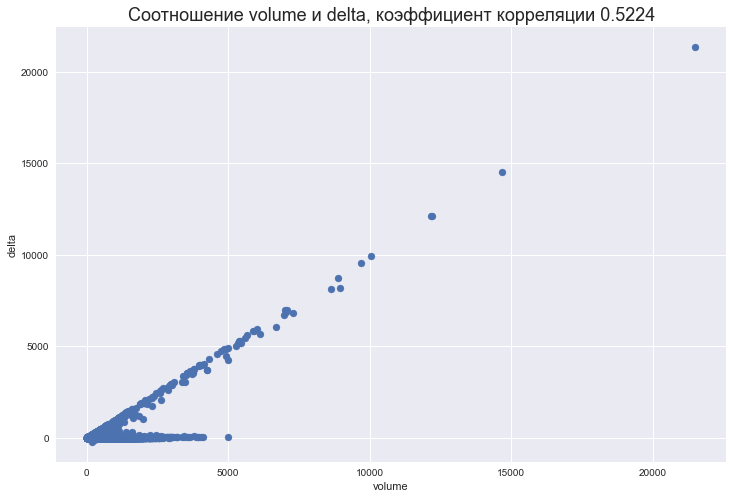

In [8]:
# Посмотрим на связь на графике
fig, ax = plt.subplots(figsize=(12,8))
plt.scatter(df.volume, df.delta)
ax.set_xlabel('volume')
ax.set_ylabel('delta')
ax.set_title('Соотношение volume и delta, коэффициент корреляции %.4f' % (
    df.volume.corr(df.delta))
    , fontsize=18);

Наблюдается ожидаемая четкая закономерность: чем больше трафик, тем больше "секретных" автомобилей. Этой закономерности подчиняются также далеко отстоящие правые значения.

Значения, которые не подчиняются закономерности, сосредоточены по горизонтали при x > 800 и малых значениях y. В этих точках, несмотря на большое количество трафика, количество "секретных" автомобилей близко к нулю. Также выбросами является небольшое количество минусовых значений дельты, которых не может быть по условиям задачи. Отфильтруем эти значения.

In [9]:
# Отбор выбросов по условию. Количество значений
anomal = df[(df.volume > 800) & (df.delta < 500) | (df.delta < 0)]
len(anomal)

4562

In [10]:
# Отбор значений без выбросов, количество значений
df_clear = df[~df.index.isin(anomal.index)]
len(df_clear)

95438

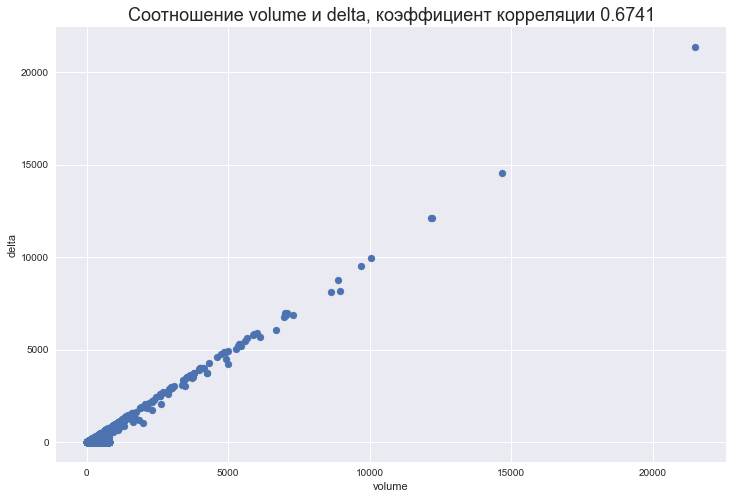

In [11]:
# Обновленное соотношение volume и delta на графике
fig, ax = plt.subplots(figsize=(12,8))
plt.scatter(df_clear.volume, df_clear.delta)
ax.set_xlabel('volume')
ax.set_ylabel('delta')
ax.set_title('Соотношение volume и delta, коэффициент корреляции %.4f' % (
    df_clear.volume.corr(df_clear.delta))
    , fontsize=18);

In [12]:
# Коэффициенты корреляции
df_clear.corr()

,volume,volume_calc,delta
volume,1.000000,0.735617,0.674084
volume_calc,0.735617,1.000000,-0.004495
delta,0.674084,-0.004495,1.000000


Корреляция между общим и "официальным" количеством автомобилей ожидаемо снизилась, так как теперь меньше значений разницы равных нулю между ними. Сила связи между общим количеством и дельта повысилась, так как мы обнаружили и усилили имевшуюся закономерность: чем выше трафик, тем больше количество "секретных" автомобилей

In [13]:
# Заменяем выбросы на NaN'ы в исходном датафрейме
df.loc[df.index.isin(anomal.index), :] = np.nan

# Проверяем количество NaN'ов
len(df[df.isnull().all(1)])

4562

### Шаг 3

Нормализуем переменную delta при помощи линейного преобразования: поместим все значения дельты в коридор, например, от 0 до 5000. Затем пересчитаем значение volume_calc

*Примечание* Размер "коридора", конечно, будет зависеть от конкретной модели и от величины других используемых фичей. Здесь это скорее просто пример

In [14]:
# Применяем нормализацию из библиотеки sklearn
df['delta_norm'] = MinMaxScaler(feature_range=(0,5000)).fit_transform(np.array(df.delta).reshape(-1,1))
df.head()

,volume,volume_calc,delta,delta_norm
0,12.0,10.0,2.0,0.467858
1,234.0,230.0,4.0,0.935716
2,26.0,26.0,0.0,0.000000
3,20.0,16.0,4.0,0.935716
4,42.0,42.0,0.0,0.000000


In [15]:
# Округлим значения нормализованной дельты до целых чисел, так как речь в задаче идет об автомобилях

# ПРИМЕЧАНИЕ. Возможно, округлять стоит не на этом шаге, а на более поздних этапах. Это зависит от модели и метрик
# качества, которые получатся

df['delta_norm_round'] = np.round(df.delta_norm)
df.head()

,volume,volume_calc,delta,delta_norm,delta_norm_round
0,12.0,10.0,2.0,0.467858,0.0
1,234.0,230.0,4.0,0.935716,1.0
2,26.0,26.0,0.0,0.000000,0.0
3,20.0,16.0,4.0,0.935716,1.0
4,42.0,42.0,0.0,0.000000,0.0


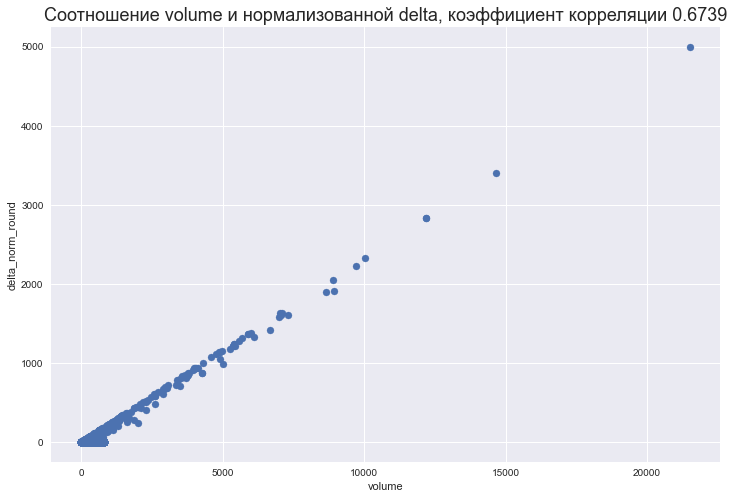

In [16]:
# Посмотрим на связь между новой дельтой и количеством автомобилей
fig, ax = plt.subplots(figsize=(12,8))
plt.scatter(df.volume, df.delta_norm_round)
ax.set_xlabel('volume')
ax.set_ylabel('delta_norm_round')
ax.set_title('Соотношение volume и нормализованной delta, коэффициент корреляции %.4f' % (
    df.volume.corr(df.delta_norm_round))
    , fontsize=18);

In [17]:
# Закономерности сохранились

# Остается только пересчитать "официальное" количество volume_calc
df['volume_calc_norm'] = df.volume - df.delta_norm_round
df.head()

,volume,volume_calc,delta,delta_norm,delta_norm_round,volume_calc_norm
0,12.0,10.0,2.0,0.467858,0.0,12.0
1,234.0,230.0,4.0,0.935716,1.0,233.0
2,26.0,26.0,0.0,0.000000,0.0,26.0
3,20.0,16.0,4.0,0.935716,1.0,19.0
4,42.0,42.0,0.0,0.000000,0.0,42.0


### Общие выводы

Таким образом, мы отобрали 95 438 значений из 100 000 исходных, пригодных для обучения модели. На первом шаге мы избавились от значений delta, которые не подчиняются общей закономерности: при увеличении общего количества автомобилей должно увеличиваться количество скрытых. Затем мы применили нормализацию и поместили все значения разницы-дельты в "коридор" от 0 до 5000. Наконец, задали новую переменную volume_calc_norm, которая представляет собой volume минус нормализованная дельта. Эту новую переменную можно использовать для обучения модели.

При этом необходимо понимать, что в вопросе определения выбросов не может быть идеального решения. Многое зависит от результатов обучения непосредственно самой модели и получившихся метрик качества модели. Поэтому на каждом шаге возможны другие тактики: можно увеличить / уменьшить размер "коридора" при нормализации, проводить округление до целых самой дельты, или переменной volume_calc_norm, или обучать модель на дробных значениях и т.д.